# Введение

В данной проектной работе будет произведен анализ двух тарифов сотовой связи **Ультра** и **Смарт** на основе выборки за 2018 г. В ходе исследования будет проведено преобразование данных, анализ данных на предмет того, сколько минут звонков, сообщений и трафика тратят абоненты, а также проверены 2 гипотезы, касающиеся выручки по данным тарифам.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

# 1. Загрузка файлов данных
Для проведения исследования откроем предложенные датафреймы и присвоим каждому из них свое имя. В следующем шаге мы подробно расмотрим каждый датафрейм и проверим его на корректность данных

In [2]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

# 2. Подготовка данных
Посмотрим информацию о датафреймах и при необходимости произведем предобработку данных.

## 2.1 Звонки - data_calls
Воспользуемся методом `info()` и посмотрим информацию о датафрейме **data_calls**. Видно, что в датафрейме 4 столбца и отсутствуют пропуски данных. Здесь я предлагаю заменить тип столбца **call_date** на `datetime` - т.к. здесь рассматривается дата звонка, которую удобно рассматривать именно в формате дата/время. И преобразуем столбец **duration** в тип `int`, предварительно воспользовавшись функцией `np.ceil()` для округления "наверх". 
(в примечании указано, что все звонки округляются до минут). Для проверки посчитаем сумму значений по столбцу **duration** до и после преобразований (если округление прошло корректно, т.е. "наверх", сумма длительности звонков после преобразования будет больше, нежели ранее)

In [3]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format = '%Y-%m-%d')

In [6]:
print(data_calls['duration'].sum())

data_calls['duration'] = np.ceil(data_calls['duration'])
data_calls['duration'] = data_calls['duration'].astype('int16')
data_calls['duration'].sum()

1368790.0399999998


1450301

Как видим, преобразование столбца **duration** прошло успешно - сумма длительности звонков увеличилась, столбец **call_date** был успешно преобразован в тип `datetime64`.
Однако в нашей выгрузке могут быть данные за разные месяцы (по условиям задачи, в датафрейме содержатся данные только за 2018 г.). Создадим столбец **month**, куда выгрузим порядковый номер месяца звонков. 

In [7]:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month

## 2.2. Интернет- сессии - data_internet

В этой таблице видим, что произошел дубль столбца с индексами - такая же информация есть в столбце **Unnamed: 0** - удалим этот столбец. Округлять трафки пока не будем, т.к. округление происходит по общей сумме за месяц. 
Также произведем преобразование столбца **session_date** в тип даты - `datetime64` и создадим столбец **month** с месяцем интернет-сессий. 

In [8]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [9]:
data_internet.tail()

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [10]:
data_internet = data_internet.drop(columns = 'Unnamed: 0', axis = 1)
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format = '%Y-%m-%d')
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month
data_internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


## 2.3. Cообщения- data_messages

Посмотрим инфо о датафрейме **data_messages**- видно, что пропуски в датафрейме отсутствуют. Изменим тип столбца **message_date** на `datetime64` и добавим месяц отправки сообщений **month**: 

In [11]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [12]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format = '%Y-%m-%d')
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month
data_messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


## 2.4. Тарифы - data_tariffs
Если загрузим информацию о датафрейме **data_tariffs**, также видим, что здесь все корректно, никаких изменений не требуется. 

In [13]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [14]:
data_tariffs #здесь все ОК

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## 2.5. Пользователи - data_users
В этом датафрейме также все заполнено верно, есть пропуски в столбце **churn_date**, но так должно быть- в этом столбце указана дата прекращения пользования тарифом, многие пользователи до сих пор продолжают им пользоваться. Изменим только тип данных в столбцах **reg_date** и **churn_date** на `datetime64`:

In [15]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format = '%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format = '%Y-%m-%d')
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


## 2.6. Расчет трат каждого пользователя

Произведем расчет ежемесячных трат для каждого пользователя. 
Для этого: 
- Создадим сводные таблицы по датафреймам **data_calls**, **data_internet**, **data_messages**, где посчитаем суммарное количество продолжительности звонков, использования траффика и сообщений по каждому **user_id** ежемесячно **month**.
- Создадим таблицу-словаь с использованием столбцов **user_id** и названием тарифа **tariff**.
- Соединим эти таблицы в единую таблицу **users_table**, будем использовать метод слияния **outer** (т.е. или). Выбираю такой способ потому, что человек может не звонить, но активно отправлять сообщения и пользоваться интернетом, к примеру. 
- Проведем преобразования таблицы: пересчитаем трафик в Гб, округлив "наверх" при помощи функции `np.ceil()`, переименуем колонки и заполним пропуски 0 (если есть пропуск, значит, в этом месяце данным способом связи не пользовались).
- Соединим таблицу **users_table** c таблицей стоимости тарифов **data_tariffs**, здесь будем соединять способом **left**. 
- Преобразуем количество включенного в тариф траффика в Гб.

In [17]:
calls_pivot = data_calls.pivot_table(index = ['user_id','month'], values = 'duration', 
                                     aggfunc = 'sum').sort_values(by = ['user_id', 'month']).reset_index()
calls_pivot.head()

,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


In [18]:
internet_pivot = data_internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', 
                                           aggfunc = 'sum').sort_values(by = ['user_id', 'month']).reset_index()
internet_pivot.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [19]:
messages_pivot = data_messages.pivot_table(index = ['user_id', 'month'], values = 'id', 
                                           aggfunc = 'count').sort_values(by = ['user_id', 'month']).reset_index()
messages_pivot.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [20]:
tariffs_users  = data_users[['user_id', 'tariff', 'age', 'city']]

In [21]:
users_table = calls_pivot.merge(internet_pivot, on = ['user_id', 'month'], how = 'outer')
users_table = users_table.merge(messages_pivot, on = ['user_id', 'month'], how = 'outer')
users_table = users_table.merge(tariffs_users, on = ['user_id'], how = 'left')

In [22]:
users_table.head()

,user_id,month,duration,mb_used,id,tariff,age,city
0,1000,5,159.0,2253.49,22.0,ultra,52,Краснодар
1,1000,6,172.0,23233.77,60.0,ultra,52,Краснодар
2,1000,7,340.0,14003.64,75.0,ultra,52,Краснодар
3,1000,8,408.0,14055.93,81.0,ultra,52,Краснодар
4,1000,9,466.0,14568.91,57.0,ultra,52,Краснодар


In [23]:
users_table['mb_used'] = np.ceil((users_table['mb_used'] / 1024))
users_table.columns = ['user_id', 'month', 'calls', 'internet', 'messages', 'tariff_name', 'age', 'city']
users_table = users_table.fillna(0)

In [24]:
users_table.head()

,user_id,month,calls,internet,messages,tariff_name,age,city
0,1000,5,159.0,3.0,22.0,ultra,52,Краснодар
1,1000,6,172.0,23.0,60.0,ultra,52,Краснодар
2,1000,7,340.0,14.0,75.0,ultra,52,Краснодар
3,1000,8,408.0,14.0,81.0,ultra,52,Краснодар
4,1000,9,466.0,15.0,57.0,ultra,52,Краснодар


In [25]:
users_table = users_table.merge(data_tariffs, on = 'tariff_name', how = 'left')

In [26]:
users_table['gb_per_month_included'] = (users_table['mb_per_month_included'] / 1024)
users_table = users_table.drop(columns = 'mb_per_month_included', axis = 1)

In [27]:
users_table.tail()

,user_id,month,calls,internet,messages,tariff_name,age,city,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
3209,1489,8,0.0,11.0,17.0,smart,35,Санкт-Петербург,50,500,550,200,3,3,15.0
3210,1489,9,0.0,17.0,32.0,smart,35,Санкт-Петербург,50,500,550,200,3,3,15.0
3211,1489,10,0.0,20.0,21.0,smart,35,Санкт-Петербург,50,500,550,200,3,3,15.0
3212,1489,11,0.0,18.0,20.0,smart,35,Санкт-Петербург,50,500,550,200,3,3,15.0
3213,1489,12,0.0,17.0,35.0,smart,35,Санкт-Петербург,50,500,550,200,3,3,15.0


Для расчета ежемесячной оплаты напишем 3 функции: 
- cost_calls - стоимость звонков,
- cost_internet - стоимость интернета,
- cost_messages - стоимость сообщений. 

Применим функции к нашей таблице и посчитаем стоимость по каждому пункту. В столбце **final_cost** просуммируем полученные данные с ежемесячной стоимостью тарифа и получим финальный счет. После этого преобразуем некоторые столбцы таблицы в тип int16.

In [28]:
def cost_calls (row):
    calls = row['calls']
    minutes = row['minutes_included']
    rub_per_minute = row ['rub_per_minute']
    
    if calls > minutes:
        cost_calls = (calls - minutes)* rub_per_minute
        return cost_calls
    return 0

In [29]:
def cost_internet (row):
    internet = row['internet']
    gb_included = row['gb_per_month_included']
    rub_per_gb = row ['rub_per_gb']
    
    if internet > gb_included:
        cost_internet = (internet - gb_included)* rub_per_gb
        return cost_internet
    return 0

In [30]:
def cost_messages (row):
    messages = row['messages']
    messages_included = row['messages_included']
    rub_per_message = row ['rub_per_message']
    
    if messages > messages_included:
        cost_messages = (messages - messages_included)* rub_per_message
        return cost_messages
    return 0

In [31]:
users_table['cost_calls'] = users_table.apply(cost_calls, axis = 1)
users_table['cost_internet'] = users_table.apply(cost_internet, axis = 1)
users_table['cost_messages'] = users_table.apply(cost_messages, axis = 1)
users_table['final_cost'] = users_table['cost_calls'] + users_table['cost_internet'] + users_table['cost_messages'] + users_table['rub_monthly_fee']

In [32]:
col_types = ['calls', 'internet', 'messages', 'final_cost']
for col in users_table.columns:
    if col in col_types:
        users_table[col] = users_table[col].astype('int16')

In [33]:
users_table.head()

,user_id,month,calls,internet,messages,tariff_name,age,city,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,cost_calls,cost_internet,cost_messages,final_cost
0,1000,5,159,3,22,ultra,52,Краснодар,1000,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950
1,1000,6,172,23,60,ultra,52,Краснодар,1000,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950
2,1000,7,340,14,75,ultra,52,Краснодар,1000,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950
3,1000,8,408,14,81,ultra,52,Краснодар,1000,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950
4,1000,9,466,15,57,ultra,52,Краснодар,1000,3000,1950,150,1,1,30.0,0.0,0.0,0.0,1950


Для упрощения работы создадим окончательный датафрейм **users_final_cost** на основе **users_table**, куда добавим только данные о пользователе, активности за месяц и стоимости. 

In [34]:
users_final_cost = users_table[['user_id', 'month', 'calls', 'internet', 'messages', 'final_cost', 'tariff_name', 'age', 'city', ]].sort_values(by = 'user_id').reset_index(drop = True)

In [35]:
users_final_cost.head()

,user_id,month,calls,internet,messages,final_cost,tariff_name,age,city
0,1000,5,159,3,22,1950,ultra,52,Краснодар
1,1000,6,172,23,60,1950,ultra,52,Краснодар
2,1000,7,340,14,75,1950,ultra,52,Краснодар
3,1000,8,408,14,81,1950,ultra,52,Краснодар
4,1000,9,466,15,57,1950,ultra,52,Краснодар


Проверим, не попали ли в список те пользователи, которые уже расторгли контракт с оператором. 
Для этого сделаем таблицу **data_users_churn**, куда попадут пользователи с проставленной датой расторжения контракта - таких 38.
Затем уберем тех пользователей, у которых нулевая активность и проставлена дата расторжения контракта. Таких пользователей нет, значит, оставляем таблицу **users_final_cost** без изменений. 

In [36]:
data_users_churn = data_users.query('churn_date == churn_date')
len(data_users_churn)

38

In [37]:
users_final_cost.query('user_id in @data_users_churn.user_id and (calls == internet == messages)')

,user_id,month,calls,internet,messages,final_cost,tariff_name,age,city


Проверим, сколько пользователей не попало в нашу таблицу. Найдем количество пользователей до объединения таблиц и после. Видим, что у нас "выпало" 2 пользователя. Если мы сделаем запрос по таблице пользователей, то найдем пользователей, которые не попали в объединенную таблицу. Как видно, эти абоненты не пользовались услугами связи, поэтому и не попали в сводную таблицу (а в конце 2018 г. контракт и вовсе был расторгнут)

In [39]:
len(data_users.groupby('user_id'))

500


In [40]:
len(users_final_cost.groupby('user_id'))

498

In [41]:
data_users.query('user_id not in @users_final_cost.user_id')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [42]:
calls_pivot.query('user_id not in @users_final_cost.user_id')

,user_id,month,duration


In [43]:
internet_pivot.query('user_id not in @users_final_cost.user_id')

,user_id,month,mb_used


In [45]:
messages_pivot.query('user_id not in @users_final_cost.user_id')

,user_id,month,id


**Вывод по блоку:** 

В процессе подготовки данных были проведены преобразования над входящими датафреймами, такие как: 
- изменение типов данных;
- объединение даных в сводные таблицы;
- создание новых столбцов с данными, полученными в результате вычислений. 

Итоговая таблица готова к анализу и нахождению закономерностей.

# 3.Анализ полученных данных.

Создадим сводную таблицу и проанализируем основные показатели по пользователям каждого тарифа. 
Видно, что больше всего тратят на услуги связи пользователи тарифа **ultra** (в среднем, разница с тарифом **smart** -более чем 1,5 раза, 2070.15 руб/1289.97 руб.) 
В среднем тратят:

**По тарифу smart:**
- 418 мин. звонков, 16.33 Гб. интернета, 33 сообщений в месяц со средней оплатой 1289.97 руб. в месяц.

**По тарифу ultra:**
- 527 мин. звонков, 19.49 Гб. интернета, 49 сообщений в месяц со средней оплатой 2070.15  руб. в месяц.

Видно, что в среднем пользователи тарифа **smart** превышают заложенный в тариф объем услуг связи по параметру "интернет", что отражается на средней оплате за месяц. Пользователи тарифа **ultra** в среднем вписываются в существующий лимит.

In [46]:
round(users_final_cost.pivot_table(index = ['tariff_name'], values = ['calls', 'internet', 'messages','final_cost']), 2)

,calls,final_cost,internet,messages
tariff_name,,,,
smart,417.93,1289.97,16.33,33.38
ultra,526.62,2070.15,19.49,49.36


## 3.1. Анализ потраченных минут за месяц

Построим гистограммы количества потраченных минут в месяц по каждому тарифу. Тариф **smart** отображается голубым цветом, а тариф **ultra** - оранжевым. 

По гистограмме видно, что: 

Тариф **smart**:
- Больше всего пользователей тратят от 380 до 580 минут в месяц (пиковое значение- от 380 до 480 мин).
- Достаточно большое количество пользователей тратят от 0 до 380 мин. 
- Меньшее количество абонентов тратит от 580 до 760 мин.
- Единичные пользователи трятят от 760 до 1050 мин. 

Тариф **ultra**:
- Большая часть абонентов тратит от 0 до 880 мин. разговоров в месяц - гистограмма довольно равномерная, с небольшим провалос в диапазоне 100-220 мин, и небольшим пиком в районе 500 мин. 
- Далее количество звонков идет на спад до 1500-1600 мин. (с единичными значениями в районе 1600 мин.)

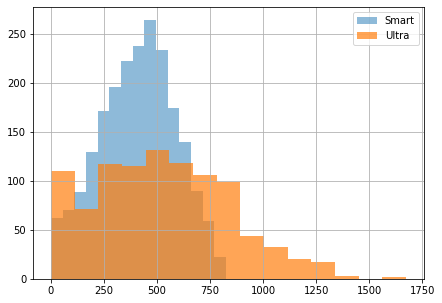

In [89]:
users_final_cost.query('tariff_name == "smart"')['calls'].hist(bins = 15, alpha = 0.5, figsize = (7, 5))
users_final_cost.query('tariff_name == "ultra"')['calls'].hist(bins = 15, alpha = 0.7, figsize = (7, 5))
plt.legend(['Smart', 'Ultra'])

Т.к. в дальнейшем мы будем находить дисперсию и стандартное отклонение, на которое большое влияние оказывают выбросы, я предлагаю убрать единичные значения, так мы сможем точнее рассчитать дисперсию. Найдем длину исходного датафрейма и сравним с длиной запроса по фильтру:

In [48]:
len(users_final_cost) #длина исходного датафрейма

3214

In [49]:
len(users_final_cost.query('(tariff_name == "smart" and calls > 825) or (tariff_name == "ultra" and calls > 1200)'))

66

Видно, что отсортированные значения составляют около 2% датафрейма. Удалим их, чтобы они не мешали нашей выборке.

In [50]:
users_final_cost = users_final_cost.query('not(tariff_name == "smart" and calls > 825) or (tariff_name == "ultra" and calls > 1200)')
len(users_final_cost)

3176

## 3.2. Анализ потраченного траффика за месяц

По аналогии с предыдущим шагом сделаем гистограммы потраченного траффика на разных тарифах. 

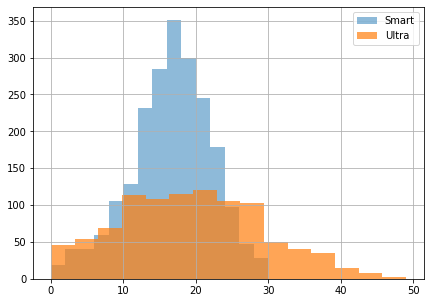

In [90]:
users_final_cost.query('tariff_name == "smart"')['internet'].hist(bins = 15, alpha = 0.5, figsize = (7, 5))
users_final_cost.query('tariff_name == "ultra"')['internet'].hist(bins = 15, alpha = 0.7, figsize = (7, 5))
plt.legend(['Smart', 'Ultra'])

Видно, что пользователи тарифа **smart** крайне неоднородно потребляют траффик - пиковое потребление находится на границе 15 гб, включенных в тариф. Немалая часть пользователей тратит от 10 до 15 Гб и также входит в предел потребления. Однако есть большая группа пользователей, потребляющих интернет больше, чем заложено в тариф- от 15 до 22 Гб. Свыше 27 Гб тратят уже единичные абоненты. 

У пользователей тарифа **ultra** гистограмма распределния схожа с гистограммой расходования минут. Большая часть абонентов тратит не более положенных 30 Гб в месяц, причем гистограмма довольна равномерна по своим значениям на диапазоне от 10 до 30 Гб. Далее гистограмма идет на спад, однако присутствует группа абонентов, которая тратит от 30 до 40 Гб в месяц. Меньше 40 Гб- единичные значения. 
Также уберем из анализа единичные значения траффика, которых здесь около 1%. 

In [52]:
print(len(users_final_cost.query(
    '(tariff_name == "smart" and internet > 30) or (tariff_name == "ultra" and internet > 40)')))
users_final_cost = users_final_cost.query(
    'not(tariff_name == "smart" and internet > 30) or (tariff_name == "ultra" and internet > 40)')

37


## 3.3. Анализ отправки сообщений

Построим гистограммы, отображающие, сколько сообщений отправили абоненты в месяц. 

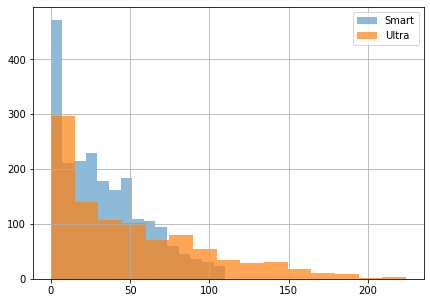

In [91]:
users_final_cost.query('tariff_name == "smart"')['messages'].hist(bins = 15, alpha = 0.5, figsize = (7, 5))
users_final_cost.query('tariff_name == "ultra"')['messages'].hist(bins = 15, alpha = 0.7, figsize = (7, 5))
plt.legend(['Smart', 'Ultra'])

Т.к. сейчас сервис отправки сообщений изживает себя и заменяется интернет-мессенджерами, гистограмма четко показывает, что большая группа абонентов обоих тарифов отправляет не более 10 сообщений в месяц. Большая часть абонентов тарифа **smart** вписывается в порог 50 сообщений в месяц, меньшая группа тратит от 50 до 100 сообщений в месяц. 

Все абоненты тарифа **ultra** вписываются в порог тарифа- 1000 сообщений в месяц, здесь также большая часть абонентов тратит от 0 до 50 сообщений в месяц, меньшая- от 50 до 150 сообщений. Единичные пользователи тратят от 150 до 220 сообщений в месяц. 

Здесь также уберем единичные значения для уменьшения влияния на дисперсию. 
Затем найдем длину получившегося датафрейма и видим, что количество строк уменьшилось по сравнению с началом анализа всего на 3%, что является допустимым. 

In [54]:
print(len(users_final_cost.query(
    '(tariff_name == "smart" and messages > 110) or (tariff_name == "ultra" and messages > 150)')))
users_final_cost = users_final_cost.query(
    'not(tariff_name == "smart" and messages > 110) or (tariff_name == "ultra" and messages > 150)')
len(users_final_cost)

58


3143

## 3.4. Анализ ежемесячной оплаты
Построим гистограмму по размеру ежемесячных расходов абонентов. 

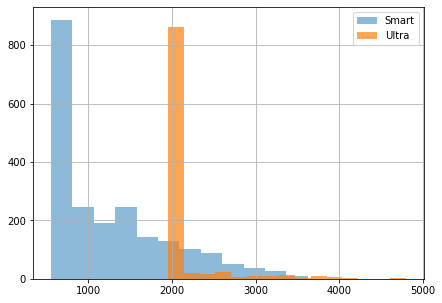

In [92]:
users_final_cost.query('tariff_name == "smart"')['final_cost'].hist(bins = 15, alpha = 0.5, figsize = (7, 5))
users_final_cost.query('tariff_name == "ultra"')['final_cost'].hist(bins = 15, alpha = 0.7, figsize = (7, 5))
plt.legend(['Smart', 'Ultra'])

По гистограмме видно, что пиковые значения оплат находятся на уровне значений стоимости тарифа, однако видна следующая особенность: практически все пользователи тарифа **ultra** платят либо фиксированную стоимость, либо незначительно ее превышают, тогда как ориентировочно больше половины пользователей тарифа **smart** не вписываются в ежемесячную стоимость. 
Проверим эту гипотезу далее, после нахождения статистических показателей. 

## 3.5. Подсчет среднего количества, дисперсии и стандартного отклонения

Рассчитаем значение среднего, дисперсии и стандартного отклонения для каждого из параметров, а также построим график нормального распределения. Здесь мы будем пользоваться именно нормальным распределением, т.к.:
- данная ситуация не попадает к биномиальному распределению - мы рассматриваем непрерывные величины, а не дискретные;
- при большой выборке любое распределение стремится к нормальному. 

Т.к. в нашем распоряжении вся генеральная совокупность, будет пользоваться формулами расчета именно для нее. 
Здесь и далее:
- `mean_` - среднее значение
- `disp_` - дисперсия
- `std_`- стандартное отклонение

### 3.5.1 Статистические значения звонков для тарифов smart и ultra

При помощи библиотеки `numpy` найдем значения среднего, дисперсии и стандартного отклонения для тарифа **smart**, а также зададим нормальное распределение:

In [56]:
mean_smart_calls = round((users_final_cost.query('tariff_name == "smart"')['calls']).mean(), 2)
disp_smart_calls = round((np.var(users_final_cost.query('tariff_name == "smart"')['calls'])), 2)
std_smart_calls = round((np.std(users_final_cost.query('tariff_name == "smart"')['calls'])), 2)
smart_calls = st.norm(mean_smart_calls, std_smart_calls)

print(mean_smart_calls)
print(disp_smart_calls)
std_smart_calls

407.16
31938.75


178.71

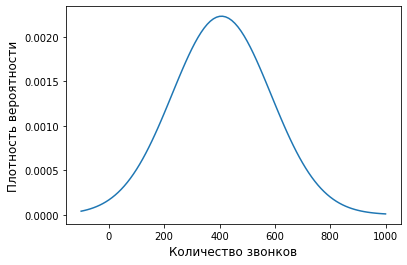

In [57]:
x = np.linspace(-100, 1000, 100)

plt.plot(x, norm.pdf(x, loc=mean_smart_calls, scale=std_smart_calls))
plt.xlabel('Количество звонков', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()      

Видно, что стандартное отклонение довольно большое (ок. 40% от среднего), что указывает на большой разброс данных. 

Найдем эти же значения по столбцу **calls** для тарифа **ultra**:

In [58]:
mean_ultra_calls = round((users_final_cost.query('tariff_name == "ultra"')['calls']).mean(), 2)
disp_ultra_calls = round((np.var(users_final_cost.query('tariff_name == "ultra"')['calls'])), 2)
std_ultra_calls = round((np.std(users_final_cost.query('tariff_name == "ultra"')['calls'])), 2)
ultra_calls = st.norm(mean_ultra_calls, std_ultra_calls)

print(mean_ultra_calls)
print(disp_ultra_calls)
std_ultra_calls

526.62
100771.22


317.44

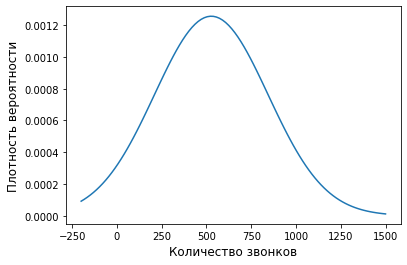

In [59]:
y = np.linspace(-200, 1500, 100)

plt.plot(y, norm.pdf(y, loc=mean_ultra_calls, scale=std_ultra_calls))
plt.xlabel('Количество звонков', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()     

Видно, что среднее количество потраченных минут, как и стандартное отклонение по тарифу **ultra** выше, чем по тарифу  **smart**, что указывает на больший раброс потраченных минут. Если мы посмотрим на ось ординат, то увидим, что график плотности распределния минут на тарифе **ultra** имеет пик ниже, чем на тарифе **smart** и более распластан по оси абсцисс. Это обуславливается бОльшим отклонением на тарифе **ultra** и, соответственно, увеличением интервала нахождения результатов. 

Найдем вероятность попадания количества звонков в отведенное тарифом количество минут.
Видим, что для тарифа **smart** эта вероятность равна 70%, для тарифа **ultra** (для существующей генеральной совокупности)- 100%.

In [60]:
prob_smart_calls = round(smart_calls.cdf(500), 2) #smart
prob_smart_calls

0.7

In [61]:
prob_ultra_calls = round(ultra_calls.cdf(3000), 2)  #ultra
prob_ultra_calls

1.0

### 3.5.2 Статистические значения трафика для тарифов smart и ultra
По порядку, расписанному в предыдущем пункте, найдем статистические показатели потребления траффика для абонентов тарифов **smart** и **ultra**. 
Начнем с тарифа **smart**:

In [62]:
mean_smart_internet = round((users_final_cost.query('tariff_name == "smart"')['internet']).mean(), 2)
disp_smart_internet = round((np.var(users_final_cost.query('tariff_name == "smart"')['internet'])), 2)
std_smart_internet = round((np.std(users_final_cost.query('tariff_name == "smart"')['internet'])), 2)
smart_internet = st.norm(mean_smart_internet, std_smart_internet)

print(mean_smart_internet)
print(disp_smart_internet)
std_smart_internet

16.13
30.76


5.55

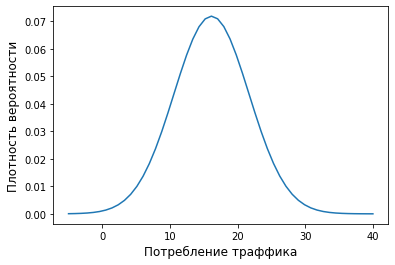

In [63]:
a = np.linspace(-5, 40, 50)

plt.plot(a, norm.pdf(a, loc=mean_smart_internet, scale=std_smart_internet))
plt.xlabel('Потребление траффика', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

И найдем те же самые параметры для тарифа **ultra** по столбцу **internet**:

In [64]:
mean_ultra_internet = round((users_final_cost.query('tariff_name == "ultra"')['internet']).mean(), 2)
disp_ultra_internet = round((np.var(users_final_cost.query('tariff_name == "ultra"')['internet'])), 2)
std_ultra_internet = round((np.std(users_final_cost.query('tariff_name == "ultra"')['internet'])), 2)
ultra_internet = st.norm(mean_ultra_internet, std_ultra_internet)

print(mean_ultra_internet)
print(disp_ultra_internet)
std_ultra_internet

19.49
96.99


9.85

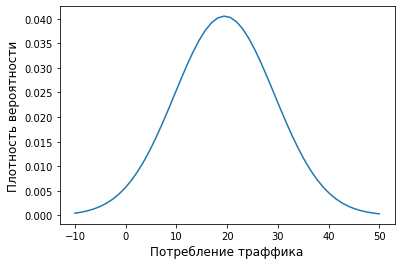

In [65]:
b = np.linspace(-10, 50, 50)

plt.plot(b, norm.pdf(b, loc=mean_ultra_internet, scale=std_ultra_internet))
plt.xlabel('Потребление траффика', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

При анализе трафика подтверждаются выводы, полученные по гистограмме: 
- Разница в средних значениях по тарифам **smart** и **ultra** не так велика (`16.13/19.49`, т.е. около 20%), однако стандартное отклонение имеет разницу почти в 50% (`5.55\9.85`), что опять же указывает на уплощенность распределения потребления трафика по тарифу **ultra** и большую разбросанность значений, нежели по тарифу **smart**. 
- Пики на графике соответствуют пикам потребления на гистограмме. 

Снова проверим вероятность попадания абонентом в отведенное количество трафика. 
Вероятность попадания в лимит трафика по тарифу **smart** - 42%, и по тарифу **ultra** - 86%. 

In [66]:
prob_smart_internet = round(smart_internet.cdf(15), 2) #smart
prob_smart_internet

0.42

In [67]:
prob_ultra_internet = round(ultra_internet.cdf(30), 2)  #ultra
prob_ultra_internet

0.86

### 3.5.3 Статистические значения отправки сообщений для тарифов smart и ultra
Найдем необходимые статистические значения для столбца **messages**.
По тарифу **smart**:

In [68]:
mean_smart_messages = round((users_final_cost.query('tariff_name == "smart"')['messages']).mean(), 2)
disp_smart_messages = round((np.var(users_final_cost.query('tariff_name == "smart"')['messages'])), 2)
std_smart_messages = round((np.std(users_final_cost.query('tariff_name == "smart"')['messages'])), 2)
smart_messages = st.norm(mean_smart_messages, std_smart_messages)

print(mean_smart_messages)
print(disp_smart_messages)
std_smart_messages

32.58
728.82


27.0

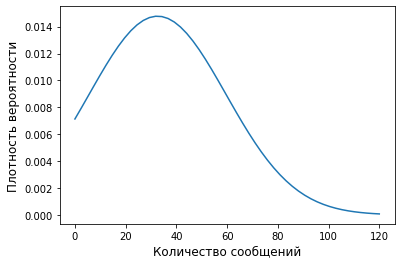

In [69]:
c = np.linspace(0, 120, 50)

plt.plot(c, norm.pdf(c, loc=mean_smart_messages, scale=std_smart_messages))
plt.xlabel('Количество сообщений', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

И по тарифу **ultra**:

In [70]:
mean_ultra_messages = round((users_final_cost.query('tariff_name == "ultra"')['messages']).mean(), 2)
disp_ultra_messages = round((np.var(users_final_cost.query('tariff_name == "ultra"')['messages'])), 2)
std_ultra_messages = round((np.std(users_final_cost.query('tariff_name == "ultra"')['messages'])), 2)
ultra_messages = st.norm(mean_ultra_messages, std_ultra_messages)

print(mean_ultra_messages)
print(disp_ultra_messages)
std_ultra_messages

49.36
2282.95


47.78

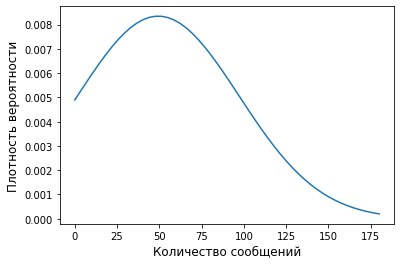

In [71]:
d = np.linspace(0, 180, 50)

plt.plot(d, norm.pdf(d, loc=mean_ultra_messages, scale=std_ultra_messages))
plt.xlabel('Количество сообщений', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

Здесь мы видим, что графики смещены относительно оси Х  и пики находятся слишком близко к оси. Это также подтверждается гистограммой, где пики по обеим тарифам находятся в интервале около 0. Однако среднее значение все-таки отлично от 0 и так же, как и было раньше- график по тарифу **ultra** имеет большее среднее отклонение и уплощен относительно графика **smart**.
Посчитаем и здесмь вероятность попадания в количество сообщений, отведенных тарифом.
Для тарифа **ultra** вероятность так же высока, как и со звонками- 1, для тарифа **smart** она также немалая и составляет 0,74. 

In [72]:
prob_smart_messages = round(smart_messages.cdf(50), 2) #smart
prob_smart_messages

0.74

In [73]:
prob_ultra_messages = round(ultra_messages.cdf(1000), 2) #ultra
prob_ultra_messages

1.0

### 3.5.4 Статистические значения ежемесячной оплаты для тарифов smart и ultra
Найдем статистические значения для среднего счета по тарифу **smart**:

In [74]:
mean_smart_cost = round((users_final_cost.query('tariff_name == "smart"')['final_cost']).mean(), 2)
disp_smart_cost = round((np.var(users_final_cost.query('tariff_name == "smart"')['final_cost'])), 2)
std_smart_cost = round((np.std(users_final_cost.query('tariff_name == "smart"')['final_cost'])), 2)
smart_cost = st.norm(mean_smart_cost, std_smart_cost)

print(mean_smart_cost)
print(disp_smart_cost)
std_smart_cost

1232.66
527403.11


726.23

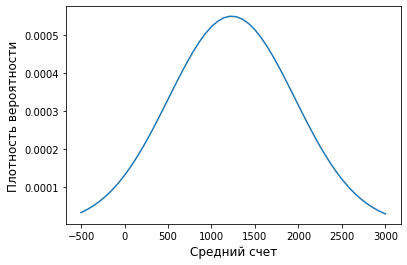

In [75]:
e = np.linspace(-500, 3000, 50)

plt.plot(e, norm.pdf(e, loc=mean_smart_cost, scale=std_smart_cost))
plt.xlabel('Средний счет', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

И по тарифу **ultra**:

In [76]:
mean_ultra_cost = round((users_final_cost.query('tariff_name == "ultra"')['final_cost']).mean(), 2)
disp_ultra_cost = round((np.var(users_final_cost.query('tariff_name == "ultra"')['final_cost'])), 2)
std_ultra_cost = round((np.std(users_final_cost.query('tariff_name == "ultra"')['final_cost'])), 2)
ultra_cost = st.norm(mean_smart_cost, std_smart_cost)

print(mean_ultra_cost)
print(disp_ultra_cost)
std_ultra_cost

2070.15
141373.07


376.0

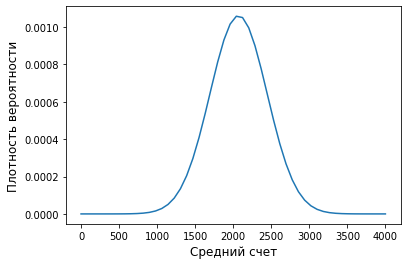

In [77]:
f = np.linspace(0, 4000, 50)

plt.plot(f, norm.pdf(f, loc=mean_ultra_cost, scale=std_ultra_cost))
plt.xlabel('Средний счет', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.show()

Если рассмотреть графики, то первое, что можно увидеть: 
- средняя помесячная оплата на тарифе **smart** выше, чем помесячная оплата по тарифу более чем в 2 раза- `1232.66/550.00` руб., т.е. большинство абонентов этого тарифа превышают лимиты. 
- средняя оплата абонентов тарифа **ultra** также выше фиксированной оплаты по тарифу, но незначительно- `2070.15/1950.00`
- среднее отклонение по тарифу **smart** в 2 раза выше, чем по тарифу **ultra**, что характеризует увеличенный разброс данных. 
Гипотеза о том, что пользователи тарифа **smart** превышают фиксированную оплату подтверждается нахождением вероятности. Вероятность попасть в ежемесячный лимит стоимости по тарифу **smart** составляет 17%, зато по тарифу **ultra** - целых 84%. 

In [78]:
prob_smart_cost = round(smart_cost.cdf(550), 2) #smart
prob_smart_cost

0.17

In [79]:
prob_ultra_cost = round(ultra_cost.cdf(1950), 2) #ultra
prob_ultra_cost

0.84

**Вывод по блоку**: 

Был произведен анализ основных параметров (количество минут, трафика, сообщений и ежемесячная оплата) абонентов тарифов **smart** и **ultra**, найдены статистические показатели, построены гистограммы и графики распределения. 
В ходе исследования было выявлено, что пользователи тарифа **smart** зачастую выходят за пределы установленных лимитов и как следствие- тратят намного больше, чем ежемесячная плата по тарифу. 

# 4. Проверка гипотез.

## 4.1. "Средняя выручка тарифов "Ультра" и "Смарт" различаются. 

Для проверки гипотезы используем гипотезу о равенстве среднего парных выборок. 
Определим нулевую и альтернативную гипотезы: 

- **Н_0**: "Выборочное среднее совокупности по тарифу "Смарт"- равно выборочному среднему совокупности по тарифу "Ультра"
- **Н_1**: "Выборочное среднее совокупности по тарифу "Смарт"- НЕ равно выборочному среднему совокупности по тарифу "Ультра"

Для проверки используем метод `st.ttest_rel` и зададим `alpha = 0.05`. 
Т.к. для такого метода выборки должны быть равны, сделаем выборки из генеральной совокупности по 100 элементов каждая и проверим гипотезу: 

In [80]:
sample_smart = users_final_cost.query('tariff_name == "smart"')['final_cost']
smart_array = np.asarray(sample_smart)
stat_smart = np.random.choice(smart_array, 100)

In [81]:
sample_ultra = users_final_cost.query('tariff_name == "ultra"')['final_cost']
ultra_array = np.asarray(sample_ultra)
stat_ultra = np.random.choice(ultra_array, 100)

In [82]:
alpha = .05 # критический уровень статистической значимости

result_tariff = st.ttest_rel(stat_ultra, stat_smart)

print('p-значение: ', result_tariff.pvalue)

if result_tariff.pvalue < alpha:
    print("Верна альтернативная гипотеза Н_1")
else:
    print("Верна нулевая гипотеза Н_0") 

p-значение:  5.155529212867259e-25
Верна альтернативная гипотеза Н_1


Таким образом, после проверки была отвергнута нулевая гипотеза Н0 в пользу альтернативной гипотезы Н1: "Выборочное среднее совокупности по тарифу "Смарт"- НЕ равно выборочному среднему совокупности по тарифу "Ультра".

## 4.2. "Средняя выручка пользователей из Москвы отличается от выручки в других регионах

Здесь мы используем метод проверки односторонней гипотезы (у нас будет правосторонняя) и используем метод `st.ttest_1samp` 

Гипотезы: 

- **Н_0**: "Средняя выручка пользователей из Москвы- равна средней выручке абонентов из регионов"
- **Н_1**: "Средняя выручка пользователей из Москвы- БОЛЬШЕ средней выручке абонентов из регионов"

Также создадим массив **array_moscow** и сравним со средним значением выручки в регионе **mean_region**:

In [83]:
sample_moscow = users_final_cost.query('city == "Москва"')['final_cost']
array_moscow = np.asarray(sample_moscow) 

In [84]:
mean_region = users_final_cost.query('not(city == "Москва")')['final_cost'].mean()

In [85]:
alpha = 0.05

result_region = st.ttest_1samp(array_moscow, mean_region)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', result_region.pvalue / 2)


if (result_region.pvalue / 2 < alpha) and (array_moscow.mean() > mean_region):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение: 0.057885267603854665
Не отвергаем нулевую гипотезу


Видим, что здесь нулевая гипотеза не была отвергнута (Н_0: "Средняя выручка пользователей из Москвы- равна средней выручке абонентов из регионов"). 

Для подтверждения этого я также сравнила средние значения генеральной совокупности. Видно, что эти значения различаются незначительно, поэтому не отвергаем сформированную нулевую гипотезу. 

In [86]:
array_moscow.mean()

1532.8297520661158

In [87]:
mean_region

1486.1343577620173

# Вывод

В ходе практической работы было выполнено исследование расходования связи пользователями двух тарифных планов. 
В процессе анализа основных показателей (звонки, трафик, сообщения, ежемесячная оплата) было выявлено, что большинство пользователей тарифа **Смарт** не укладываются в отведенные тарифом параметры и оплачивают дополнительные услуги связи. 
Например, немало пользователей тратят от 500 до 760 мин. в месяц (при включенных в тариф 500 минутах), а также используют до 20 Гб интернета в месяц (при включенных в тариф 30 Гб). Все это приводит к систематическим переплатам абонентов за связь и превышению ежемесячного счета до 1000-1500 руб. в месяц (что составляет 100-200% от ежемесячной стоимости тарифного плана).  

Пользователи тарифа **Ультра**, в свою очередь, намного чаще (с вероятностью 84%) не выходят за пределы установленного лимита по интернету и трафику, что позволяет практически всем пользователям не тратить более, чем предусмотрено тарифом. 

Этот вывод был получен в ходе исследования соответствующих гистограмм, анализа графика распределения и основны статистических параметров по каждому из пунктов, таких как: среднее, дисперсия и среднее отклонения. 

Также были проверены две гипотезы- одна методом равенства среднего парных выборок, вторая - методом проверки односторонней гипотезы. В ходе проверки было выяснено, что средняя величина выручки по тарифам **Смарт** и **Ультра** различаются, а вот средняя величина выручки не зависит от региона абонента. 

После исследования можно сделать вывод: несмотря на то, что абоненты тарифа **Смарт** постоянно выходят за пределы того объема связи, что предусмотрен тарифом и, соответственно, переплачивают, для сотового оператора все равно выгоднее тариф **Ультра**, как приносящий большее количество выручки. Из-за высокой абонентской платы, средняя сумма, потраченная абонентами тарифа **Ультра** на связь все равно выше, чем средний счет абонента тарифа **Смарт**, а количество потраченных минут и траффика хоть и отличается, но не на порядок. 